# Global Temporal Split

## Описание пайлайна Global Time Split

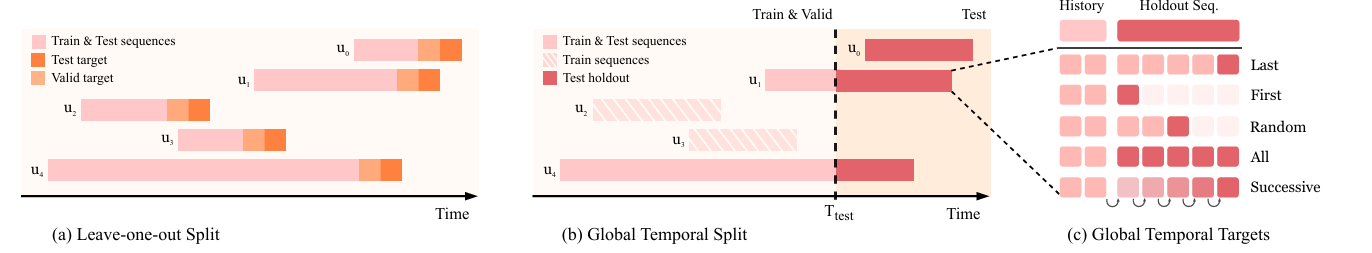

В ходе работы сплита образуются три сущности:
- `train` - обучающий набор данных;
- `test_input` - входные данные для теста (история пользователя);
- `test_target` - целевые значения для теста (следующий предсказываемый айтем);

1) Используя `TimeSplitter` разбиваем данные на трейн и тест, по временному порогу `T_test`.
2) Фильтрация тестового набора данных (например, убираем холодные пользователей или элементы).
3) Выделение `test_input` из обучающего набора.
4) Удаление из трейна пользователей, история которых включает лишь один айтем (__опционально__).
5) Формирование тестового набора, используя одну из доступных стратегий (`First`, `Last`, `Random`, `All`).

In [13]:
import random
import pandas as pd

from functools import partial
from typing import Literal
from datetime import datetime
from replay.splitters import TimeSplitter
from replay.utils import (
    DataFrameLike,
    PandasDataFrame,
    PolarsDataFrame,
    SparkDataFrame,
)

In [25]:
columns = ["query_id", "item_id", "timestamp"]

data = [
         (1, 1, "01-01-2020"),
         (1, 2, "02-01-2020"),
         (1, 3, "03-01-2020"),
         (1, 4, "04-01-2020"),
         (1, 5, "05-01-2020"),
         (1, 6, "06-01-2020"),
         (1, 7, "07-01-2020"),
         (2, 1, "06-01-2020"),
         (2, 2, "07-01-2020"),
         (2, 3, "08-01-2020"),
         (2, 9, "09-01-2020"),
         (2, 10, "10-01-2020"),
         (3, 1, "01-01-2020"),
         (3, 5, "02-01-2020"),
         (3, 3, "03-01-2020"),
         (3, 1, "04-01-2020"),
         (3, 2, "05-01-2020"),
         (3, 4, "06-01-2020"),
         (3, 6, "07-01-2020"),
         (4, 7, "01-01-2020"),  
         (4, 8, "07-01-2020"),
         (5, 8, "02-01-2020"),
]

dataset = pd.DataFrame(data, columns=columns)
dataset["timestamp"] = pd.to_datetime(dataset["timestamp"], format="%d-%m-%Y")
dataset.head()

,query_id,item_id,timestamp
0,1,1,2020-01-01
1,1,2,2020-01-02
2,1,3,2020-01-03
3,1,4,2020-01-04
4,1,5,2020-01-05


## Utils
(реализация вспомогательных функций)

In [26]:
def _filter_cold_start_pandas(
    train: PandasDataFrame,
    test: PandasDataFrame,
    filter_users: bool = True,
    filter_items: bool = True,
    query_coumn: str = "query_id",
    item_column: str = "item_id",
):
    """
    Filters users and/or items that are not in the train from the test.
    """
    if filter_users:
        test = test[test[query_coumn].isin(train[query_coumn].unique())]
    if filter_items:
        test = test[test[item_column].isin(train[item_column].unique())]
    return train, test

In [27]:
def _filter_single_item_users_pandas(
    dataset: PandasDataFrame,
    user_column: str = "query_id",
    item_column: str = "item_id",
) -> PandasDataFrame:
    """
    Removes users from dataset who have only one unique item.
    """
    user_counts = dataset.groupby(user_column)[item_column].nunique()
    valid_users = user_counts[user_counts > 1].index
    return dataset[dataset[user_column].isin(valid_users)]

In [28]:
def _split_test_sequence_pandas(series: pd.Series, strategy: Literal["first", "last", "all", "random"]) -> pd.DataFrame:
    if len(series) == 0:
        return pd.DataFrame(columns=["test_history_part", "test_targets"])
    
    if strategy == "first":
        return pd.DataFrame(
            [[[], series.tolist()[0]]],
            columns=["test_history_part", "test_targets"],
        )
    elif strategy == "last":
        return pd.DataFrame(
            [[series.tolist()[:-1], series.tolist()[-1]]],
            columns=["test_history_part", "test_targets"],
        )
    elif strategy == "random":
        idx = random.randint(0, len(series) - 1)
        return pd.DataFrame(
            [[series.tolist()[:idx], series.tolist()[idx]]],
            columns=["test_history_part", "test_targets"],
        )
    elif strategy == "all":
        test_history_part = []
        test_targets = []
        for i in range(0, len(series)):
            test_history_part.append(series.tolist()[:i])
            test_targets.append(series.tolist()[i])
        return pd.DataFrame(
            zip(test_history_part, test_targets),
            columns=["test_history_part", "test_targets"],
        )


def _prepare_sequential_test_set_pandas(
    train: PandasDataFrame,
    test: PandasDataFrame,
    strategy: Literal["last", "all", "random"] = "last",
    query_column: str = "query_id",
    item_column: str = "item_id",
    timestamp_column: str = "timestamp",
):
    train.sort_values(by=[query_column, timestamp_column], inplace=True)
    test.sort_values(by=[query_column, timestamp_column], inplace=True)
    
    if strategy not in ["first", "last", "all", "random"]:
        raise ValueError("Strategy must be one of 'first', 'last', 'all', or 'random'.")
    
    train_history = train.groupby(query_column)[item_column].apply(list).reset_index()
    train_history.rename(columns={item_column: "train_history"}, inplace=True)
    
    split_test_sequence = partial(_split_test_sequence_pandas, strategy=strategy)
    
    test_processed = test.groupby(query_column)[item_column].apply(split_test_sequence).reset_index()

    final_test = pd.merge(train_history, test_processed, on=query_column, how="inner")
    final_test["test_inputs"] = final_test["train_history"] + final_test["test_history_part"]
        
    return final_test[[query_column, "test_inputs", "test_targets"]]

In [29]:
def _global_time_split_pandas(
    dataset: PandasDataFrame,
    time_threshold: datetime,
):
    train, test = TimeSplitter(
        time_threshold=datetime.strptime("2020-01-04", "%Y-%M-%d")
    ).split(dataset)
    
    train, test = _filter_cold_start_pandas(train, test)
    
    final_test = _prepare_sequential_test_set_pandas(train, test, strategy="last")
    
    train = _filter_single_item_users_pandas(train)
    
    return train, final_test

In [31]:
train, test = TimeSplitter(
    time_threshold=datetime.strptime("2020-01-04", "%Y-%M-%d")
).split(dataset)

In [32]:
print(test.shape)
test

(12, 3)


,query_id,item_id,timestamp
4,1,5,2020-01-05
5,1,6,2020-01-06
6,1,7,2020-01-07
7,2,1,2020-01-06
8,2,2,2020-01-07
9,2,3,2020-01-08
10,2,9,2020-01-09
11,2,10,2020-01-10
16,3,2,2020-01-05
17,3,4,2020-01-06


In [33]:
train, test = _filter_cold_start_pandas(train, test)

In [34]:
print(test.shape, train.shape)
test

(5, 3) (10, 3)


,query_id,item_id,timestamp
4,1,5,2020-01-05
6,1,7,2020-01-07
16,3,2,2020-01-05
17,3,4,2020-01-06
20,4,8,2020-01-07


In [35]:
final_test = _prepare_sequential_test_set_pandas(train, test, strategy="last")

In [36]:
final_test

,query_id,test_inputs,test_targets
0,1,"[1, 2, 3, 4, 5]",7
1,3,"[1, 5, 3, 1, 2]",4
2,4,[7],8


In [37]:
print(train.shape)
train = _filter_single_item_users_pandas(train)
print(train.shape)

(10, 3)
(8, 3)
